In [1]:
%%bash
[[ -z "$COLAB_RELEASE_TAG" ]] && exit

pip install -U accelerate
pip install -U transformers
pip install datasets
pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

the previous cell is executed only in colab

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, confusion_matrix
from pathlib import Path
import torch
from transformers import (
    BertTokenizer,
    BertModel,
    Trainer,
    TrainingArguments,
)

import tqdm.notebook as tq
from datasets import Dataset
from typing import Tuple, Union
from torcheval.metrics.functional import multiclass_f1_score
import matplotlib.pyplot as plt

In [3]:
from torch import cuda

device = "cuda" if cuda.is_available() else "cpu"

## Corpus

In [4]:
# The data is in the root of the GDrive storage if running colab or in the same folder if running locally
try:
    from google.colab import drive

    drive.mount("/content/drive")
    data_path = Path("/content/drive/MyDrive/MELD_train_efr.json")
except:
    data_path = Path("data/MELD_train_efr.json")

Mounted at /content/drive


In [5]:
# Load corpus

assert data_path.exists(), "Data file is not present"
raw_df = pd.read_json(data_path, dtype={"speakers": np.array})
# , "triggers": np.array})
EPISODE, SPEAKERS, EMOTIONS, UTTERANCES, TRIGGERS = raw_df.columns

#### Data exploration

In [6]:
raw_df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


In [7]:
raw_df.describe()

,episode,speakers,emotions,utterances,triggers
count,4000,4000,4000,4000,4000
unique,4000,3350,3427,3998,523
top,utterance_3960,"[Monica, Chandler, Monica]","[neutral, neutral, joy]",[Happy?! Is that what I'm supposed to be Vic? ...,"[0.0, 1.0, 0.0]"
freq,1,15,30,2,191


In [8]:
# Look for how many groups of episodes with the same first utterance there are and their lenghts

raw_df.sort_values(by=UTTERANCES, inplace=True)
groups = np.zeros((850,), dtype=int)

index = 0
count = 1
for i in range(1, len(raw_df[UTTERANCES])):
    if raw_df[UTTERANCES][i][0] == raw_df[UTTERANCES][i - 1][0]:
        # still in the same group
        count += 1
    else:
        # found new group
        groups[index] = count
        index += 1
        count = 1

groups = groups[groups != 0]

print(f"Number of groups: {len(groups)}")
print(f"Avg group len: {np.average(groups):.1f}")
print(f"Longest group: {np.max(groups)}")
print(f"Episodes not in a group: {groups[groups == 1].shape[0]}")

Number of groups: 832
Avg group len: 4.8
Longest group: 16
Episodes not in a group: 128


In [9]:
# Count how many speakers there are in each episode

speakers_count = raw_df[SPEAKERS].apply(lambda arr: np.unique(arr).shape[0]).to_numpy()
min_sp = np.min(speakers_count)
max_sp = np.max(speakers_count)
print("Distribution of number of speakers:")
for count in range(min_sp, max_sp + 1):
    print(f"{count} speakers:  {np.sum(speakers_count == count)}")

Distribution of number of speakers:
1 speakers:  214
2 speakers:  2105
3 speakers:  1030
4 speakers:  405
5 speakers:  161
6 speakers:  74
7 speakers:  10
8 speakers:  1


In [10]:
# Class imbalance check
classes_count = {}
for emotions in raw_df["emotions"]:
    for emotion in emotions:
        if emotion in classes_count:
            classes_count[emotion] += 1
        else:
            classes_count[emotion] = 1

# then we sort the dictionary by occurences
emotions_dict = {
    k: v
    for k, v in sorted(classes_count.items(), key=lambda item: item[1], reverse=True)
}
print("Classes values:")
print(emotions_dict)

# Classes counts are not balanced: the use of weights is recommended

Classes values:
{'neutral': 15263, 'joy': 6317, 'surprise': 4645, 'anger': 3964, 'sadness': 2648, 'fear': 1114, 'disgust': 1049}


#### Data cleanup

In [11]:
# Drop not useful column

raw_df.drop(columns=[SPEAKERS], inplace=True)

In [12]:
# Remove Nones from the triggers

raw_df[TRIGGERS] = raw_df[TRIGGERS].apply(
    lambda trig_seq: np.array([0.0 if t is None else t for t in trig_seq])
)

In [13]:
# Change column "episode" from utterance_xyz to episode_xyz
for i in range(len(raw_df)):
    raw_df[EPISODE][i] = f"episode_{raw_df[EPISODE][i][10:]}"

clean_df = raw_df
clean_df.head()

,episode,emotions,utterances,triggers
1061,episode_1061,"[joy, neutral, surprise]","[""Happy birthday to you!"", You're paying for t...","[0.0, 1.0, 0.0]"
1062,episode_1062,"[joy, neutral, surprise, surprise]","[""Happy birthday to you!"", You're paying for t...","[0.0, 0.0, 1.0, 0.0]"
1063,episode_1063,"[joy, neutral, surprise, surprise, neutral]","[""Happy birthday to you!"", You're paying for t...","[0.0, 0.0, 0.0, 1.0, 0.0]"
1064,episode_1064,"[joy, neutral, surprise, surprise, neutral, ne...","[""Happy birthday to you!"", You're paying for t...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
1065,episode_1065,"[joy, neutral, surprise, surprise, neutral, ne...","[""Happy birthday to you!"", You're paying for t...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


### Data preprocessing:


If an episode contains the same utterances of the previous and a few more then the triggers from the previous episode are replicated in the current episode

In [14]:
for i in range(10):
    print(f"{raw_df[TRIGGERS][i]}")

[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 1. 0.]
[0. 1. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 1. 0.]


In [15]:
# Replicate triggers

count = 0
for i in range(1, len(clean_df)):
    is_continuation = np.all(
        [u in clean_df[UTTERANCES][i] for u in clean_df[UTTERANCES][i - 1]]
    )
    if is_continuation:
        count += 1
        for k, t in enumerate(clean_df[TRIGGERS][i - 1]):
            clean_df[TRIGGERS][i][k] = t

In [16]:
for i in range(10):
    print(f"{raw_df[TRIGGERS][i]}")

[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 1. 0.]
[0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
[0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 1. 0.]
[0. 1. 0.]
[0. 1. 0. 1.]
[0. 1. 0. 1. 0.]


In [17]:
# Train Val Test split: 80/10/10


def split_data(
    df: pd.DataFrame, seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_train, df_test = train_test_split(
        df, test_size=0.2, train_size=0.8, random_state=seed
    )

    df_val, df_test = train_test_split(
        df_test, test_size=0.5, train_size=0.5, random_state=seed
    )

    return df_train, df_val, df_test

In [18]:
# Check
df_train_t, df_val_t, df_test_t = split_data(clean_df)
print(f"df_train len: {len(df_train_t)}")
print(f"df_val len:   {len(df_val_t)}")
print(f"df_test len:  {len(df_test_t)}")

df_train len: 3200
df_val len:   400
df_test len:  400


explode the dataframe: <br>
each rows contains: previous utterance, target utterance, next utterance (for context). <br>
Except for the first and lat utterance of each episode that have no previous and next utterance, respectively

In [19]:
def explode_add_context_old(df: pd.DataFrame, ctxt_win_len: int = 1) -> pd.DataFrame:
    # context_window = number of utterances before and number of utterance after the current sentence.

    # Flatten the lists of utterances,triggers,emotions into new rows of the dataframe
    exploded_df = df.explode([UTTERANCES, TRIGGERS, EMOTIONS], ignore_index=True)
    exploded_df.rename(columns={UTTERANCES: "current"}, inplace=True)
    exploded_df.head(10)

    # Pair shifted columns of utterances to the exploded df to make previous and next
    for i in range(1, ctxt_win_len + 1):
        padding_cells = pd.Series([" " for _ in range(i)])

        previous_col = pd.concat(
            (padding_cells, exploded_df["current"][:-i]), copy=False
        ).to_list()
        exploded_df.insert(loc=2, column=f"previous_-{i}", value=previous_col)

        next_col = pd.concat(
            (exploded_df["current"][i:], padding_cells), copy=False
        ).to_list()
        exploded_df.insert(loc=2 + 2 * i, column=f"next_{i}", value=next_col)

    # Remove the previous of the first utterance and the next of the last utterance of each episode
    for i in range(1, len(exploded_df) - 1):
        for j in range(1, ctxt_win_len + 1):
            if exploded_df[EPISODE][i] != exploded_df[EPISODE][i - 1]:
                exploded_df[f"next_{j}"][i - j] = " "
                exploded_df[f"previous_-{j}"][i] = " "

    exploded_df.sort_values(by=EPISODE, inplace=True)
    # TODO sortare prima su episode poi sull'indice
    return exploded_df

In [20]:
all_emotions = df_train_t[EMOTIONS].explode().to_numpy()
uniq_emotions = np.sort(np.unique(all_emotions))
# uniq_emotions = ["neutral", "joy", "surprise", "anger", "sadness", "disgust", "fear"]
one_hot = np.identity(len(uniq_emotions), dtype=int)
emotion_mapping = {e: one_hot[i] for i, e in enumerate(uniq_emotions)}
max_em_len = np.max([len(v) for v in emotion_mapping.values()]) + 1
for k, e in emotion_mapping.items():
    print(f"{k}:{' '*(max_em_len - len(k))} {e}")

anger:    [1 0 0 0 0 0 0]
disgust:  [0 1 0 0 0 0 0]
fear:     [0 0 1 0 0 0 0]
joy:      [0 0 0 1 0 0 0]
neutral:  [0 0 0 0 1 0 0]
sadness:  [0 0 0 0 0 1 0]
surprise: [0 0 0 0 0 0 1]


In [21]:
def explode_add_context(df: pd.DataFrame, ctxt_win_len: int = 1) -> pd.DataFrame:

    new_df = {"emotion": [], "trigger": [], "hist_curr": [], "next": [], "episode": []}

    utt_separator = " "  # TODO va bene ' ' come separatore?
    # for each original row
    for _, row in df.iterrows():
        # create as many new rows as utterances in the original row
        for utt_idx, (emo, trig) in enumerate(zip(row[EMOTIONS], row[TRIGGERS])):
            new_df["emotion"].append(emo)
            new_df["trigger"].append(trig)
            new_df["episode"].append(row["episode"])

            # previous utterances + current (same way triggers are defined)
            start_hist = np.max((0, utt_idx - ctxt_win_len))
            curr_incl = utt_idx + 1
            hist_curr = utt_separator.join(row[UTTERANCES][start_hist:curr_incl])
            new_df["hist_curr"].append(hist_curr)

            # next utterances
            curr_excl = utt_idx + 1
            last_next_excl = utt_idx + ctxt_win_len + 1
            next = utt_separator.join(row[UTTERANCES][curr_excl:last_next_excl])
            new_df["next"].append(next)

    new_df = pd.DataFrame(new_df)
    # important: the new_df still has utterances grouped by episode (to make the metrics work), otherwise we sort
    new_df.sort_values(by=EPISODE, inplace=True)

    return new_df

In [59]:
# ctxt_win_len = 2
# ctxt_win_len = 3
ctxt_win_len = 4

df_train = explode_add_context(df_train_t, ctxt_win_len)
df_val = explode_add_context(df_val_t, ctxt_win_len)
df_test = explode_add_context(df_test_t, ctxt_win_len)

In [60]:
df_train.head(10)

,emotion,trigger,hist_curr,next,episode
864,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_0
868,surprise,0.0,also I was the point person on my company's tr...,,episode_0
867,neutral,1.0,also I was the point person on my company's tr...,My duties? All right.,episode_0
866,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_0
865,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_0
24390,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_1
24389,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_1
24391,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_1
24395,neutral,0.0,That I did. That I did. So let's talk a little...,,episode_1
24392,neutral,1.0,also I was the point person on my company's tr...,My duties? All right. Now you'll be heading a...,episode_1


In [61]:
for idx in range(10 if len(df_train) >= 10 else len(df_train)):
    print(f"{df_train['hist_curr'][idx]}  -->  {df_train['next'][idx]}\n")

Cause every time I see your face, I can't help but fall from grace. I know.....  -->  Wow! This girl is good. Oh-ho yeah! A song with rhyming words. Oo, I never thought of that before. I like her. Why? Because she can sing and play guitar and do both at the same time?

Cause every time I see your face, I can't help but fall from grace. I know..... Wow! This girl is good.  -->  Oh-ho yeah! A song with rhyming words. Oo, I never thought of that before. I like her. Why? Because she can sing and play guitar and do both at the same time?

Cause every time I see your face, I can't help but fall from grace. I know..... Wow! This girl is good. Oh-ho yeah! A song with rhyming words. Oo, I never thought of that before.  -->  I like her. Why? Because she can sing and play guitar and do both at the same time?

Cause every time I see your face, I can't help but fall from grace. I know..... Wow! This girl is good. Oh-ho yeah! A song with rhyming words. Oo, I never thought of that before. I like 

### Metrics

In [62]:
# Compute F1 score for each dialogue and return avg over dialogues
def sequence_f1(
    y_true: pd.DataFrame,
    y_pred: np.ndarray,
    target_column: str,
    avg: bool = True,
) -> Union[dict, float]:
    assert len(y_pred) == len(y_true), "y_pred and y_true must be of the same lenght"
    # assert (
    #    y_true[EPISODE].is_monotonic_increasing
    #    or y_true[EPISODE].is_monotonic_decreasing
    # ), "utterances must be sorted over the episodes"

    res = {}
    start = 0
    stop_incl = 0
    for i in range(1, len(y_pred)):
        if y_true[EPISODE][i - 1] != y_true[EPISODE][i]:
            stop_incl = i - 1
            f1 = f1_score(
                y_true=y_true[target_column][start : stop_incl + 1].to_list(),
                y_pred=y_pred[start : stop_incl + 1],
                average="micro",
            )
            res.update({y_true[EPISODE][start]: f1})
            start = i

    # np.std(list(res.values))
    return res if not avg else np.average(list(res.values()))


# Compute F1 score for the unrolled sequence
def unrolled_f1(
    y_true: pd.DataFrame,
    y_pred: np.ndarray,
    target_column: str,
) -> float:
    return f1_score(y_true[target_column].to_list(), y_pred, average="micro")

## Baseline Models:

In [63]:
# Create baseline model


class SequenceDummyClassifier(DummyClassifier):
    def __init__(self, strategy: str, seed: int = 42) -> None:
        self.seed = seed
        if not strategy.lower() in ("random", "majority"):
            raise ValueError("strategy must be in [random, majority]")
        sklearn_strategy = "uniform" if strategy == "random" else "most_frequent"
        super().__init__(strategy=sklearn_strategy, random_state=seed)

In [64]:
def experiment_baseline(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    seed: int = 42,
) -> dict:

    baseline_f1s = {}
    baseline_results = {}

    for strategy in ("Random", "Majority"):
        for target in ("emotion", "trigger"):
            clf = SequenceDummyClassifier(strategy=strategy, seed=seed)
            clf.fit(X=df_train["hist_curr"], y=df_train[target])

            res = clf.predict(X=df_test["hist_curr"])
            baseline_results.update({f"{target}_{strategy}": res})

            seq_f1 = sequence_f1(y_true=df_test, y_pred=res, target_column=target)
            baseline_f1s.update({f"sequence_f1({target}_{strategy})": seq_f1})

            unr_f1 = unrolled_f1(y_true=df_test, y_pred=res, target_column=target)
            baseline_f1s.update({f"unrolled_f1({target}_{strategy})": unr_f1})

    return baseline_f1s, baseline_results


f1s, results = experiment_baseline(df_train, df_test)
for k, v in f1s.items():
    print(f"{k} : {v}")

sequence_f1(emotion_Random) : 0.44657433160540777
unrolled_f1(emotion_Random) : 0.4330935251798561
sequence_f1(trigger_Random) : 0.6522845341422358
unrolled_f1(trigger_Random) : 0.6515107913669065
sequence_f1(emotion_Majority) : 0.44657433160540777
unrolled_f1(emotion_Majority) : 0.4330935251798561
sequence_f1(trigger_Majority) : 0.6522845341422358
unrolled_f1(trigger_Majority) : 0.6515107913669065


# Tokenization

In [65]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [66]:
ds_train = Dataset.from_pandas(df_train, preserve_index=False)
ds_val = Dataset.from_pandas(df_val, preserve_index=False)
ds_test = Dataset.from_pandas(df_test, preserve_index=False)

In [156]:
def tokenize(ds_row, tokenizer):
    if type(ds_row["emotion"]) != str:  # batchsize > 1
        emotion_encoding = []
        emotion_encoding = [emotion_mapping[e] for e in ds_row["emotion"]]
        # trigger_encoding = []
        # print(ds_row["trigger"])
        # print(ds_row["emotion"])
        trigger_encoding = [np.array([e]) for e in ds_row["trigger"]]
    else:  # batchsize == 1
        emotion_encoding = emotion_mapping[ds_row["emotion"]]
        trigger_encoding = np.array([ds_row["trigger"]])

    encoded_ds_row = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "emotion": torch.tensor(np.array(emotion_encoding), dtype=torch.float),
        "trigger": torch.tensor(np.array(trigger_encoding), dtype=torch.float),
    }

    tokenized_context = tokenizer(
        ds_row["hist_curr"],
        ds_row["next"] if ds_row["next"] != [] else None,
        truncation=True,
        padding="max_length",
        #max_length=tokenizer.model_max_length // 2,
        max_length=235,  # got by experiment: check how long the tokenization is and set it to that
        return_tensors="pt",
    )

    encoded_ds_row["input_ids"] = tokenized_context["input_ids"]
    encoded_ds_row["token_type_ids"] = tokenized_context["token_type_ids"]

    encoded_ds_row["attention_mask"] = tokenized_context["attention_mask"]

    return encoded_ds_row

In [157]:
# TEST
ds_short = Dataset.from_pandas(df_train.iloc[0:4], preserve_index=False)
print(f"cols before tokenization: {ds_short.column_names}")

ds_short_tokenized = ds_short.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=False,
    remove_columns=["hist_curr", "next"],
)
ds_short_tokenized_batched = ds_short.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=True,
    remove_columns=["hist_curr", "next"],
)
ds_short_tokenized.set_format(type="torch")
ds_short_tokenized_batched.set_format(type="torch")

print(f"cols after tokenization: {ds_short_tokenized.column_names}")

idx = 3

print("*** NO BATCH -> matrix ***")
emotion = ds_short_tokenized["emotion"][idx]
ids = ds_short_tokenized["input_ids"][idx]
print(f"ds[emotion][{idx}] = {emotion}")
print(f"type of emotion: {emotion.dtype}")
print(f"ds[input_ids][{idx}] = {ids}")
print(f"ds[input_ids][{idx}] shape = {ids.size()}")


print("\n*** BATCH -> list ***")
emotion_batch = ds_short_tokenized_batched["emotion"][idx]
ids_batch = ds_short_tokenized_batched["input_ids"][idx]
print(f"ds_batch[emotion][{idx}] = {emotion_batch}")
print(f"ds_batch[input_ids][{idx}] = {ids_batch}")
print(f"ds_batch[input_ids] shape = {ids_batch.size()}")

print("\n*** RECONSTRUCTION TEST ***")
tokens = tokenizer.convert_ids_to_tokens(ids[0])
tokens_batched = tokenizer.convert_ids_to_tokens(ids_batch)
reconstructed_string = tokenizer.convert_tokens_to_string(tokens)
reconstructed_string_batched = tokenizer.convert_tokens_to_string(tokens_batched)
print(f"original string:         {reconstructed_string}")
print(f"original string batched: {reconstructed_string_batched}")

print("___________")
print(ds_short_tokenized_batched["trigger"][0])
print(ds_short_tokenized_batched["trigger"][0].size())
# print(ds_short)

# OSSERVAZIONI:
# ds.set_format(type='torch') mette trigger ed emotion dentro a dei tensori e fa qualcosa a input_ids per cui viene stampato come matrice e non come riga
# a prescindere da set_format:  input_ids è una [[]] se tokeniziamo senza batch, è una [] se tokenizziamo con il batch

cols before tokenization: ['emotion', 'trigger', 'hist_curr', 'next', 'episode']


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

cols after tokenization: ['emotion', 'trigger', 'episode', 'input_ids', 'token_type_ids', 'attention_mask']
*** NO BATCH -> matrix ***
ds[emotion][3] = tensor([0., 0., 0., 0., 1., 0., 0.])
type of emotion: torch.float32
ds[input_ids][3] = tensor([[  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,  2194,
          1005,  1055,  6653,  2013,  1996,  1047,  2140,  1011,  1019,  2000,
         24665,  1011,  1020,  2291,  1012,  2017,  2442,  1005,  2310,  2018,
          2115,  2398,  2440,  1012,  2008,  1045,  2106,  1012,  2008,  1045,
          2106,  1012,   102,  2061,  2292,  1005,  1055,  2831,  1037,  2210,
          2978,  2055,  2115,  5704,  1012,  2026,  5704,  1029,  2035,  2157,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,

In [158]:
# Apply tokenization

batched = True
cols_to_drop = ["hist_curr", "next"]

ds_train_tokenized = ds_train.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=batched,
    remove_columns=cols_to_drop,
)
ds_train_tokenized.set_format(type="torch")

ds_test_tokenized = ds_test.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=batched,
    remove_columns=cols_to_drop,
)
ds_test_tokenized.set_format(type="torch")

ds_val_tokenized = ds_val.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=batched,
    remove_columns=cols_to_drop,
)
ds_val_tokenized.set_format(type="torch")

EMOTION, TRIGGER, EPISODE, INPUT_IDS, TOKEN_TYPE_IDS, ATTENTION_MASK = (
    ds_train_tokenized.column_names
)

Map:   0%|          | 0/28034 [00:00<?, ? examples/s]

Map:   0%|          | 0/3475 [00:00<?, ? examples/s]

Map:   0%|          | 0/3491 [00:00<?, ? examples/s]

In [159]:
# Get the tokenization len needed to avoid overflow (depends on ctxt_win_len)
train_len = np.max(np.sum(ds_train_tokenized['input_ids'].numpy() != 0, axis=1))
test_len = np.max(np.sum(ds_test_tokenized['input_ids'].numpy() != 0, axis=1))
val_len = np.max(np.sum(ds_val_tokenized['input_ids'].numpy() != 0, axis=1))

print(f"max tokenization len = {np.max([train_len, test_len, val_len])}")


235
217
206


In [160]:
print(f"columns before tokenization: {ds_train.column_names}")
print(f"columns after tokenization: {ds_train_tokenized.column_names}")

columns before tokenization: ['emotion', 'trigger', 'hist_curr', 'next', 'episode']
columns after tokenization: ['emotion', 'trigger', 'episode', 'input_ids', 'token_type_ids', 'attention_mask']


In [161]:
# Tokenization test
tokens = tokenizer.convert_ids_to_tokens(ds_train_tokenized["input_ids"][0])
string = tokenizer.convert_tokens_to_string(tokens)
original_string = ds_train["hist_curr"][0] + ds_train["next"][0]
print(original_string)
print(string)

also I was the point person on my company's transition from the KL-5 to GR-6 system.You must've had your hands full. That I did. That I did. So let's talk a little bit about your duties. My duties?  All right.
[CLS] also i was the point person on my company ' s transition from the kl - 5 to gr - 6 system . [SEP] you must ' ve had your hands full . that i did . that i did . so let ' s talk a little bit about your duties . my duties ? all right . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [162]:
# Class weighting algorithm


def compute_class_weights(
    emotions: pd.Series, root: bool = False, normalize: bool = False
) -> torch.tensor:
    labels, n_ones = np.unique(emotions.to_numpy(), return_counts=True)
    l = len(emotions)
    print(labels)
    n_zeroes = np.array([l - n for n in n_ones])

    weights = np.empty_like(n_ones, dtype=np.float32)
    for class_num, (ones, zeroes) in enumerate(zip(n_ones, n_zeroes)):
        if root:
            weights[class_num] = np.sqrt(zeroes / (ones + 1e-4))
        else:
            weights[class_num] = zeroes / (ones + 1e-4)
    if normalize:
        sum = np.sum(weights)
        weights = weights / sum

    print(f"weigts = {weights}")
    return torch.as_tensor(weights, dtype=torch.float).to(device)

# Bert Models

In [178]:
class BERTClass(torch.nn.Module):
    def __init__(self, num_emotions=7):
        super(BERTClass, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased")

        self.dropout_emo = torch.nn.Dropout(0.1)
        self.dropout_tri = torch.nn.Dropout(0.2)

        # classifiers
        self.l_emotions = torch.nn.Linear(self.bert.config.hidden_size, num_emotions)
        self.l_triggers = torch.nn.Linear(self.bert.config.hidden_size, 1)
        self.linear = torch.nn.Linear(
            self.bert.config.hidden_size, self.bert.config.hidden_size
        )
        self.relu = torch.nn.ReLU()

    def forward(self, ids, mask, token_type_ids):
        output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output = output.pooler_output

        # output, _ = self.lstm(output)

        #output = self.linear(output)
        #output_emotions = self.relu(output)
        #output_triggers = self.relu(output)
        output_emotions = self.dropout_emo(output)
        output_triggers = self.dropout_tri(output)

        output_emotions = self.l_emotions(output_emotions)
        output_triggers = self.l_triggers(output_triggers)

        return output_emotions, output_triggers

    def freeze_params(self):
        for param in self.bert.parameters():
            param.requires_grad = False

# Training Utils

In [179]:
def setup(learning_rate=1e-5, weight_decay=0.1, frozen=False):
    num_emotions = len(uniq_emotions)

    model = BERTClass(num_emotions)

    model.to(device)
    if frozen:
        model.freeze_params()
        # Verifying that the params are actually frozen
        # TODO
        # assert np.all(
        #    [not param.requires_grad for _, param in model.named_parameters()]
        # ), "model did not freeze"
    else:
        # Verifying that the params are not frozen
        assert np.all(
            [param.requires_grad for _, param in model.named_parameters()]
        ), "model unexpectedly frozen"

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    return model, optimizer

In [180]:
def loss_fn(
    outputs_emotions,
    outputs_triggers,
    emotions_labels,
    triggers_labels,
    emotion_weights=None,
    balance=0.5,
):
    assert balance < 1, "loss balancing factor must be < 1"

    emotion_lf = torch.nn.CrossEntropyLoss(weight=emotion_weights)
    emotion_loss = emotion_lf(outputs_emotions, emotions_labels) * balance

    trigger_lf = torch.nn.BCEWithLogitsLoss()
    trigger_loss = trigger_lf(outputs_triggers, triggers_labels) * (1 - balance)

    return (emotion_loss + trigger_loss) * 2

In [181]:
def get_metrics(y_true, y_pred):
    cm_emotions = confusion_matrix(y_true, y_pred)

    FP_emotions = (cm_emotions.sum(axis=0) - np.diag(cm_emotions)).sum()
    FN_emotions = (cm_emotions.sum(axis=1) - np.diag(cm_emotions)).sum()
    TP_emotions = np.diag(cm_emotions).sum()
    TN_emotions = cm_emotions.sum() - (FP_emotions + FN_emotions + TP_emotions)

    print("FP_emotions")
    print(FP_emotions)
    print("FN_emotions")
    print(FN_emotions)
    print("TP_emotions")
    print(TP_emotions)
    print("TN_emotions")
    print(TN_emotions)
    print("num_samples_emotions")
    print(len(y_true))

In [182]:
DEBUG_MODE = False

In [183]:
def decode_emotions(coded_emotion):
    idx = np.argmax(coded_emotion)
    emotions = list(emotion_mapping.keys())
    return emotions[idx]

In [184]:
# Training of the model
def train_model(train_dl, model, optimizer, emotion_weights=None):
    losses = []
    correct_predictions_emotions = 0
    correct_predictions_triggers = 0
    num_samples = 0

    # activate dropout, batch norm
    model.train()

    # initialize progress bar
    batches = tq.tqdm(
        enumerate(train_dl), total=len(train_dl), leave=True, colour="steelblue"
    )
    test_count = 0
    for batch_idx, data in batches:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        emotions_labels = data["emotion"].to(device)
        triggers_labels = data["trigger"].to(device)

        # Forward pass
        outputs_emotions, outputs_triggers = model(ids, mask, token_type_ids)

        loss = loss_fn(
            outputs_emotions,
            outputs_triggers,
            emotions_labels,
            triggers_labels,
            emotion_weights,
        )
        losses.append(loss.cpu().detach().numpy().item())

        # apply thresh 0.5
        outputs_emotions = torch.sigmoid(outputs_emotions).cpu().detach().numpy()
        outputs_triggers = (
            torch.sigmoid(outputs_triggers).cpu().detach().numpy().round()
        )

        emotions_labels = emotions_labels.cpu().detach().numpy()
        triggers_labels = triggers_labels.cpu().detach().numpy()

        correct_predictions_emotions += np.sum(
            np.argmax(outputs_emotions, axis=1) == np.argmax(emotions_labels, axis=1)
        )
        correct_predictions_triggers += np.sum(outputs_triggers == triggers_labels)

        num_samples += triggers_labels.size

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Grad descent step
        optimizer.step()

        # Update progress bar
        batches.set_description(f"")
        batches.set_postfix(batch_loss=loss.item())
        if test_count >= 5 and DEBUG_MODE:
            break
        test_count += 1

    # Si potrebbe fare una singola accuracy come media delle due, magari fuori dal training
    accuracy_emotions = float(correct_predictions_emotions) / num_samples
    accuracy_triggers = float(correct_predictions_triggers) / num_samples

    # np.mean(losses)
    return (model, accuracy_emotions, accuracy_triggers, losses)

In [185]:
def eval_model(validation_dl, model, emotion_weights=None):
    losses = []
    correct_predictions_emotions = 0
    correct_predictions_triggers = 0
    num_samples = 0
    # num_categories = next(iter(validation_dl))["labels"].shape[1]

    # accumulate data over each batch to compute the metrics
    results = {
        "episode": [],
        "emotion_pred": [],
        "emotion_true": [],
        "trigger_pred": [],
        "trigger_true": [],
    }

    # turn off dropout, fix batch norm
    model.eval()

    # show progress bar
    batches = tq.tqdm(
        enumerate(validation_dl),
        total=len(validation_dl),
        leave=True,
        colour="steelblue",
    )

    actual_emotions = []
    pred_emotions = []
    actual_trigger = []
    predicted_triggers = []

    debug_count = 0
    with torch.no_grad():
        for batch_idx, data in batches:
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            emotions_labels = data["emotion"].to(device)
            triggers_labels = data["trigger"].to(device)
            outputs_emotions, outputs_triggers = model(ids, mask, token_type_ids)

            loss = loss_fn(
                outputs_emotions,
                outputs_triggers,
                emotions_labels,
                triggers_labels,
                emotion_weights,
            )
            losses.append(loss.cpu().detach().numpy().item())

            # get the predicted outputs
            # training sigmoid is in BCEWithLogitsLoss
            outputs_emotions = torch.sigmoid(outputs_emotions).cpu().detach().numpy()
            outputs_emotions = np.argmax(outputs_emotions, axis=1)
            outputs_triggers = (
                torch.sigmoid(outputs_triggers).cpu().detach().numpy().round()
            )

            # get the real labels
            emotions_labels = emotions_labels.cpu().detach().numpy()
            emotions_labels = np.argmax(emotions_labels, axis=1)
            triggers_labels = triggers_labels.cpu().detach().numpy()

            correct_predictions_emotions += np.sum(outputs_emotions == emotions_labels)
            correct_predictions_triggers += np.sum(outputs_triggers == triggers_labels)

            num_samples += triggers_labels.size

            # update the results df
            actual_emotions.extend(
                [decode_emotions(emotion) for emotion in emotions_labels]
            )
            pred_emotions.extend(
                [decode_emotions(emotion) for emotion in outputs_emotions]
            )
            actual_trigger.extend(triggers_labels)
            predicted_triggers.extend(outputs_triggers)

            results["episode"].extend(data["episode"])
            results["emotion_pred"].extend(
                [decode_emotions(emotion) for emotion in outputs_emotions]
            )
            results["emotion_true"].extend(
                [decode_emotions(emotion) for emotion in data["emotion"]]
            )
            for i in outputs_triggers:
                results["trigger_pred"].append(i)
            # results["trigger_pred"].extend(outputs_triggers.squeeze())
            for i in data["trigger"]:
                results["trigger_true"].append(i.numpy())
            # results["trigger_true"].extend(data["trigger"].squeeze())

            if debug_count >= 5 and DEBUG_MODE:
                break
            debug_count += 1

    results["trigger_pred"] = np.array(results["trigger_pred"]).flatten()
    results["trigger_true"] = np.array(results["trigger_true"]).flatten()

    accuracy_emotions = float(correct_predictions_emotions) / num_samples
    accuracy_triggers = float(correct_predictions_triggers) / num_samples

    unrolled_f1_emotions = f1_score(
        results["emotion_true"], results["emotion_pred"], average="weighted"
    )
    unrolled_f1_triggers = f1_score(
        results["trigger_true"], results["trigger_pred"], average="weighted"
    )

    results_df = pd.DataFrame(results)
    episode_f1_emotions = sequence_f1(
        results_df[["episode", "emotion_true"]],
        results_df["emotion_pred"],
        target_column="emotion_true",
    )
    episode_f1_triggers = sequence_f1(
        results_df[["episode", "trigger_true"]],
        results_df["trigger_pred"],
        target_column="trigger_true",
    )

    return (
        accuracy_emotions,
        accuracy_triggers,
        np.mean(losses),
        unrolled_f1_emotions,
        unrolled_f1_triggers,
        episode_f1_emotions,
        episode_f1_triggers,
    )

In [186]:
def train_eval(
    train_dl,
    validation_dl,
    model,
    optimizer,
    n_epochs=1,
    save_name="0",
    emotion_weights=None,
):
    model_folder = Path.cwd().joinpath("models")
    if not model_folder.exists():
        model_folder.mkdir(parents=True)

    history = {
        "train_acc_emo": [],
        "train_acc_tri": [],
        "train_losses": [],
        "val_acc_emo": [],
        "val_acc_trig": [],
        "val_loss": [],
        "val_f1_trigger_unrolled": [],
        "val_f1_trigger_episode": [],
        "val_f1_emotion_unrolled": [],
        "val_f1_emotion_episode": [],
    }

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}/{n_epochs}")
        (
            model,
            accuracy_emotions,
            accuracy_triggers,
            train_loss,
        ) = train_model(train_dl, model, optimizer, emotion_weights)
        (
            val_accuracy_emotions,
            val_accuracy_triggers,
            val_loss,
            unrolled_f1_emotions,
            unrolled_f1_triggers,
            episode_f1_emotions,
            episode_f1_triggers,
        ) = eval_model(validation_dl, model, emotion_weights)

        print(
            f"train_loss={np.mean(train_loss):.4f}, val_loss={np.mean(val_loss):.4f}, "
            f"train_acc_emo={accuracy_emotions:.4f}, train_acc_tri={accuracy_triggers:.4f},"
            f"val_acc_emo={val_accuracy_emotions:.4f}, val_acc_tri={val_accuracy_triggers:.4f}, "
        )

        history["train_acc_emo"].append(accuracy_emotions)
        history["train_acc_tri"].append(accuracy_triggers)
        history["train_losses"].append(train_loss)
        history["val_acc_emo"].append(val_accuracy_emotions)
        history["val_acc_trig"].append(val_accuracy_triggers)
        history["val_loss"].append(val_loss)
        history["val_f1_trigger_unrolled"].append(unrolled_f1_triggers)
        history["val_f1_trigger_episode"].append(episode_f1_triggers)
        history["val_f1_emotion_episode"].append(episode_f1_emotions)
        history["val_f1_emotion_unrolled"].append(unrolled_f1_emotions)

        # save the best model
        # if f1_overall > best_f1:
        #   torch.save(
        #      model.state_dict(),
        #      Path.joinpath(model_folder, f"model_{save_name}.bin"),
        # )
        # best_f1 = f1_overall

    return history

In [187]:
def show_results(history, epoch=0):
    print("RESULTS")
    print(f"VAL ACC EMO: {history['val_acc_emo'][-1]:.3f}")
    print(f"VAL ACC TRIG: {history['val_acc_trig'][-1]:.3f}")
    print(f"VAL F1 TRIG UNROLLED: {history['val_f1_trigger_unrolled'][-1]:.3f}")
    print(f"VAL F1 TRIG EPISODE: {history['val_f1_trigger_episode'][-1]:.3f}")
    print(f"VAL F1 EMO UNROLLED: {history['val_f1_emotion_unrolled'][-1]:.3f}")
    print(f"VAL F1 EMO EPISODE: {history['val_f1_emotion_episode'][-1]:.3f}")
    tmp = []
    for h in history["train_losses"]:
        tmp.extend(h)
    plt.plot(tmp)
    plt.title("TRAIN LOSS")

In [188]:
def create_data_loaders(tokenized_datasets, batch_size):
    train_dl = torch.utils.data.DataLoader(
        tokenized_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    validation_dl = torch.utils.data.DataLoader(
        tokenized_datasets["validation"],
        batch_size=batch_size * 4,
        shuffle=False,
        num_workers=0,
    )

    test_dl = torch.utils.data.DataLoader(
        tokenized_datasets["test"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )
    return train_dl, validation_dl, test_dl

In [189]:
batch_size = 32 if not DEBUG_MODE else 2

train_dl = torch.utils.data.DataLoader(
    ds_train_tokenized, batch_size=batch_size, shuffle=True
)
validation_dl = torch.utils.data.DataLoader(
    ds_val_tokenized, batch_size=batch_size, shuffle=True
)

## Training Custom loop

In [190]:
N_EPOCHS = 1 if not (DEBUG_MODE) else 2
learning_rate = 5e-4

Epoch 1/1


  0%|          | 0/877 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss=2.2770, val_loss=2.2539, train_acc_emo=0.4354, train_acc_tri=0.6441,val_acc_emo=0.4222, val_acc_tri=0.6445, 
RESULTS
VAL ACC EMO: 0.422
VAL ACC TRIG: 0.645
VAL F1 TRIG UNROLLED: 0.505
VAL F1 TRIG EPISODE: 0.713
VAL F1 EMO UNROLLED: 0.023
VAL F1 EMO EPISODE: 0.142


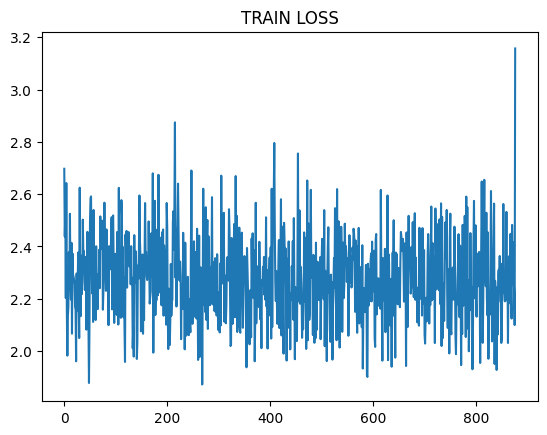

In [191]:
# FROZEN
model_frozen, optimizer = setup(learning_rate=learning_rate, frozen=True)

history_frozen = train_eval(
    train_dl,
    validation_dl,
    model=model_frozen,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    save_name=f"test_model",
)

show_results(history_frozen)

In [192]:
torch.save(model_frozen.state_dict(), Path("models/model_frozen.bin"))

In [193]:
# import csv
#
# import collections
#
# counter = collections.defaultdict(int)
# for row in history:
#    counter[row[1]] += 1
# for row in history:
#    if counter[row[1]] >= 4:
#        writer = csv.writer(open("test1.csv", "wb"))
#        writer.writerows(row)

Epoch 1/1


  0%|          | 0/877 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss=2.3056, val_loss=2.3018, train_acc_emo=0.4315, train_acc_tri=0.6423,val_acc_emo=0.4214, val_acc_tri=0.6445, 
RESULTS
VAL ACC EMO: 0.421
VAL ACC TRIG: 0.645
VAL F1 TRIG UNROLLED: 0.505
VAL F1 TRIG EPISODE: 0.667
VAL F1 EMO UNROLLED: 0.023
VAL F1 EMO EPISODE: 0.117


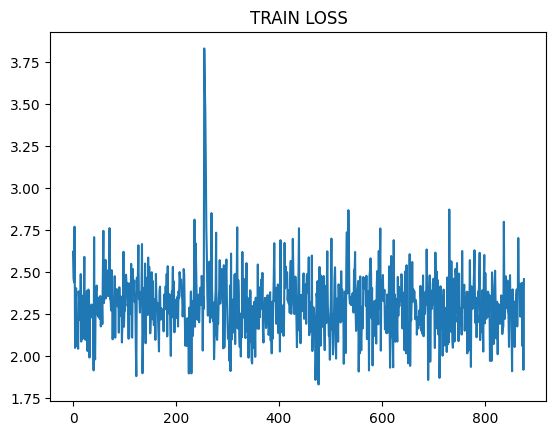

In [194]:
# FULL
model_full, optimizer = setup(learning_rate=learning_rate, frozen=False)

history_full = train_eval(
    train_dl,
    validation_dl,
    model=model_full,
    optimizer=optimizer,
    n_epochs=1,
    save_name=f"test_model",
)

show_results(history_full)

## Weights

In [195]:
1 / 0

ZeroDivisionError: division by zero

In [ ]:
emotion_weights = compute_class_weights(df_train["emotion"], root=True, normalize=True)

In [ ]:
# FROZEN weights
model_frozen_weights, optimizer = setup(learning_rate=learning_rate, frozen=True)

history_frozen_weights = train_eval(
    train_dl,
    validation_dl,
    model=model_frozen_weights,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    save_name=f"test_model",
    emotion_weights=emotion_weights,
)

show_results(history_frozen_weights)

In [ ]:
# FULL weights
model_full_weights, optimizer = setup(learning_rate=learning_rate, frozen=False)

history_full_weights = train_eval(
    train_dl,
    validation_dl,
    model=model_full_weights,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    save_name=f"test_model",
    emotion_weights=emotion_weights,
)

show_results(history_full_weights)

## Training con Classe Trainer

In [ ]:
class BertTrainer(Trainer):
    def __init__(self, model, training_args, train_ds, eval_ds, metrics):
        super().__init__(model, training_args, train_ds, eval_ds, metrics)

    def compute_loss(self, model, inputs, return_outputs=False):

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        emotions_labels = inputs["emotions"]
        triggers_labels = inputs["triggers"]
        output_emotions, output_triggers = model(ids=ids, mask=mask)

        custom_loss = self.loss_fn(
            output_emotions, output_triggers, emotions_labels, triggers_labels
        )

        return (
            (custom_loss, output_emotions, output_triggers)
            if return_outputs
            else custom_loss
        )

    def loss_fn(outputs_emotions, outputs_triggers, emotions_labels, triggers_labels):
        return torch.nn.CrossEntropyLoss(
            outputs_emotions, emotions_labels
        ) + torch.nn.BCELoss(outputs_triggers, triggers_labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="\\test",
    do_train=True,
    do_eval=True,
    # evaluate_during_training=True,
    learning_rate=5e-5,
    num_train_epochs=8,
    # seed=42,
)

In [ ]:
trainer = Trainer(
    model=model_full,
    args=training_args,
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=train_dl,
    eval_dataset=validation_dl,
    compute_metrics=sequence_f1,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()